### Imports and functions

In [6]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
import scipy.special as sps
import scipy.linalg as spl

from matplotlib import animation

# for jupyter lab
# %matplotlib inline
# %matplotlib widget
# %matplotlib 
# for jupyter notebook
%matplotlib notebook

In [5]:
# Greens functions | all dimensions | input arguments G(dim, x, xp, y, yp, z, zp)
# Raise error if dimensionality and number of input arguments do not agree.
def G(dim, x, xp, y=0, yp=0, z=0, zp=0):
    r = np.sqrt((x - xp)**2 + (y - yp)**2 + (z - zp)**2 + 1j * imaginary_shift) # the imaginary bit shifts the...
    if dim == 1:
        result = np.exp(1j * k0 * r) / (2 * 1j * k0)
    elif dim == 2:
        result = (1.0 / (4.0 * 1j)) * sps.hankel1(0, k0 * r) # ...divergence at r=0 of the Hankel function
    elif dim == 3:
        result = np.exp(1j * k0 * r) / (4 * np.pi * r) # ...divergence at r=0 of the Green's function
    else:
        raise Exception('Dimension has to be 1, 2 or 3!')
    return result

# "NOT normalised" interaction matrix - "1/\alpha_i" on the diagonal
def interaction_matrix(scatterer_locations, alphas):
#     r = 1/2/np.pi / np.abs(1/alpha_1 - 1/alpha_2)
    G_12 = G(dim, scatterer_locations[0, 0], scatterer_locations[1, 0], y=0, yp=0, z=0, zp=0)
    return np.array([[1/alphas[0], G_12],
                     [G_12, 1/alphas[1]]])

# "NORMALIZED" interaction matrix - "1" on the diagonal
def interaction_matrix_normalized(scatterer_locations, alphas):
#     r = 1/2/np.pi / np.abs(1/alpha_1 - 1/alpha_2)
    G_12 = G(dim, scatterer_locations[0, 0], scatterer_locations[1, 0], y=0, yp=0, z=0, zp=0)
    return np.array([[1, alphas[0] * G_12],
                     [alphas[1] * G_12, 1]])

# "NOT normalised" interaction matrix - "1/\alpha_i" on the diagonal
def interaction_matrix_r(alphas, r):
    G_12 = np.exp(1j * k0 * r) / (4 * np.pi * r)
    return np.array([[1/alphas[0], G_12],
                     [G_12, 1/alphas[1]]])

# "NORMALIZED" interaction matrix - "1" on the diagonal
def interaction_matrix_r_normalized(alphas, r):
    G_12 = np.exp(1j * k0 * r) / (4 * np.pi * r)
    return np.array([[1, alphas[0] * G_12],
                     [alphas[1] * G_12, 1]])

# Incident field at the scatterer's locations
def calculate_phi_i(dim, phi_s, scatterer_locations, alphas):
    M = interaction_matrix_normalized(scatterer_locations, alphas)
    phi_i = spl.solve(M, phi_s)
    return phi_i

# Total field at X and Y
def calculate_phi_tot(dim, X, Y, phi_s, scatterer_locations, alphas):
    total_field = np.zeros_like(X, dtype=complex)
    phi_i = calculate_phi_i(dim, phi_s, scatterer_locations, alphas)
    G_12 = G(dim, scatterer_locations[0, 0], scatterer_locations[1, 0], y=0, yp=0, z=0, zp=0)
    for i in range(2):
        total_field += alphas[i] * G(dim, X, scatterer_locations[i, 0], Y,
                                     scatterer_locations[i, 1]) * phi_i[i]
    return total_field

# Riemann sheets of the "NOT normalised" interaction matrix - "1/\alpha_i" on the diagonal
def riemann_sheets(alphas, k0, r):
    G_12 = np.exp(1j * k0 * r) / (4 * np.pi * r)
    M = np.array([[1/alphas[0], G_12],
                  [G_12, 1/alphas[1]]])
    return spl.eig(M)

def set_size(w, h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

### Parameters

In [7]:
alphas = [0.1 + 0.06j, 0.09 + 0.07j] # random parameters, obeying the "passivity inequality"

k0_ep = 2*np.pi * np.abs(1/alphas[0] - 1/alphas[1]) * (np.angle(1/alphas[0] - 1/alphas[1]) + np.pi/2) # Angular wavenumber
r_ep = 1/2/np.pi / np.abs(1/alphas[0] - 1/alphas[1])

dim = 3 # Dimension for Green's functions
lm = 1.0 # Base wavelength
lim = 0.4 * lm # Meshgrid limits
imaginary_shift = 1e-5 # Used in the distance r inside G to remove the singularity at r=0

# phi_s = np.array([np.random.random() + 1j * np.random.random(), 0.0], dtype=complex)

# n_steps = 2000
# r_scan = np.linspace(r_ep - 0.1, r_ep + 0.1, n_steps)
# r_scan = np.linspace(r_ep - 0.1, r_ep + 0.5, n_steps)

# scatterer_locations = 2.0 * lim * np.random.random((2,2)) - lim
# scatterer_locations[:, 1] = 0
# if scatterer_locations[0, 0] + r_ep < 1:
#     scatterer_locations[1, 0] = scatterer_locations[0, 0] + r_ep
# else:
#     scatterer_locations[1, 0] = scatterer_locations[0, 0] - r_ep

In [8]:
# def G(k0, x1, x2):
#     if np.size(x1) == np.size(x2):
#         vector_dim = np.size(x1)
#     else:
#         raise Exception('Vectors must have the same size')
#     summ = 0 + 1j * imaginary_shift
#     for i in range(vector_dim):
#         summ += (x1[i] - x2[i]) ** 2
#     r = np.sqrt(summ) # the imaginary bit shifts the...
#     if vector_dim == 1:
#         result = np.exp(1j * k0 * r) / (2 * 1j * k0)
#     elif vector_dim == 2:
#         result = (1.0 / (4.0 * 1j)) * sps.hankel1(0, k0 * r) # ...divergence at r=0 of the Hankel function
#     elif vector_dim == 3:
#         result = np.exp(1j * k0 * r) / (4 * np.pi * r) # ...divergence at r=0 of the Green's function
#     else:
#         raise Exception('Dimension has to be 1, 2 or 3!')
#     return result

# Greens functions | all dimensions | input arguments G(dim, x, xp, y, yp, z, zp)
# Raise error if dimensionality and number of input arguments do not agree.
def G(dim, k0, x, xp, y=0, yp=0, z=0, zp=0):
    r = np.sqrt((x - xp)**2 + (y - yp)**2 + (z - zp)**2 + 1j * imaginary_shift) # the imaginary bit shifts the...
    if dim == 1:
        result = np.exp(1j * k0 * r) / (2 * 1j * k0)
    elif dim == 2:
        result = (1.0 / (4.0 * 1j)) * sps.hankel1(0, k0 * r) # ...divergence at r=0 of the Hankel function
    elif dim == 3:
        result = np.exp(1j * k0 * r) / (4 * np.pi * r) # ...divergence at r=0 of the Green's function
    else:
        raise Exception('Dimension has to be 1, 2 or 3!')
    return result

# phi_s made of the "first" eigenvector of the system
def calculate_phi_s(sign_discrim, k0, scatterer_locations, alphas):
    r = np.abs(scatterer_locations[1, 0] - scatterer_locations[0, 0])
    G_12 = np.exp(1j * k0 * r) / (4 * np.pi * r)
    discrim =  np.sqrt( (alphas[0] - alphas[1])**2 + 4 * G_12**2 * alphas[0]**2 * alphas[1]**2 )
    if sign_discrim == "plus":
        result = np.array([ alphas[1] - alphas[0] + discrim / (2 * G_12 * alphas[0] * alphas[1]), 1.], dtype=complex) # first eigenvector
    elif sign_discrim == "minus":
        result = np.array([ alphas[1] - alphas[0] - discrim / (2 * G_12 * alphas[0] * alphas[1]), 1.], dtype=complex) # second eigenvector
    else:
        raise Exception('Sign of the discriminant must be "plus" or "minus"!')
    return result

# "NOT normalised" interaction matrix - "1/\alpha_i" on the diagonal
def interaction_matrix(k0, scatterer_locations, alphas):
    r = np.abs(scatterer_locations[1, 0] - scatterer_locations[0, 0])
    G_12 = np.exp(1j * k0 * r) / (4 * np.pi * r)
    return np.array([[1/alphas[0], G_12],
                     [G_12, 1/alphas[1]]])

# Incident field at the scatterer's locations
def calculate_phi_i(sign_discrim, k0, scatterer_locations, alphas):
    M = interaction_matrix(k0, scatterer_locations, alphas)
    phi_s = calculate_phi_s(sign_discrim, k0, scatterer_locations, alphas)
    phi_i = spl.solve(M, phi_s)
    return phi_i

# Total field at X and Y
def calculate_phi_tot(sign_discrim, X, Y, k0, scatterer_locations, alphas):
    n_scatt = np.ma.size(scatterer_locations, 0) # extract size number of scatterers
    total_field = np.zeros_like(X, dtype=complex)
    phi_i = calculate_phi_i(sign_discrim, k0, scatterer_locations, alphas)
    for i in range(n_scatt):
        total_field += alphas[i] * G(dim, k0, X, scatterer_locations[i, 0], Y,
                                     scatterer_locations[i, 1]) * phi_i[i]
#     r = np.abs(scatterer_locations[1, 0] - scatterer_locations[0, 0])
#     G_12 = np.exp(1j * k0 * r) / (4 * np.pi * r)
#         total_field += alphas[i] * G_12 * phi_i[i]
    return total_field

In [9]:
# square encircling on the edges of the Reimann sheets plot

n_points = 1000

k_encircling = np.concatenate((np.linspace(k0_ep + 0.05, k0_ep - 0.05, n_points), 
                               np.linspace(k0_ep - 0.05, k0_ep - 0.05, n_points), 
                               np.linspace(k0_ep - 0.05, k0_ep + 0.05, n_points),
                               np.linspace(k0_ep + 0.05, k0_ep + 0.05, n_points)))

r_encircling = np.concatenate((np.linspace(r_ep + 0.002, r_ep + 0.002, n_points), 
                               np.linspace(r_ep + 0.002, r_ep - 0.002, n_points), 
                               np.linspace(r_ep - 0.002, r_ep - 0.002, n_points),
                               np.linspace(r_ep - 0.002, r_ep + 0.002, n_points)))

# scatterer_locations[index_scatt, axis, "time_step"]
scatterer_locations = np.zeros((2, 2, n_points*4))
scatterer_locations[0, 0, :] = r_encircling

In [10]:
# X, Y = np.meshgrid(k_encircling, r_encircling) # I do not use the meshgrid for now

###############################
###############################

sign_discriminant = "plus"

sol_i_plus = np.zeros((2, n_points*4), dtype=complex)
for i in range(n_points*4):
    sol_i_plus[0, i] = calculate_phi_i(sign_discriminant, k_encircling[i], scatterer_locations[:, :, i], alphas)[0]
    sol_i_plus[1, i] = calculate_phi_i(sign_discriminant, k_encircling[i], scatterer_locations[:, :, i], alphas)[1]

sol_tot_plus = np.zeros((2, n_points*4), dtype=complex)
for i in range(n_points*4):
    sol_tot_plus[0, i] = calculate_phi_tot(sign_discriminant, scatterer_locations[0, 0, i], scatterer_locations[0, 1, i], k_encircling[i], scatterer_locations[:, :, i], alphas)
    sol_tot_plus[1, i] = calculate_phi_tot(sign_discriminant, scatterer_locations[1, 0, i], scatterer_locations[1, 1, i], k_encircling[i], scatterer_locations[:, :, i], alphas)

###############################
###############################

sign_discriminant = "minus"

sol_i_minus = np.zeros((2, n_points*4), dtype=complex)
for i in range(n_points*4):
    sol_i_minus[0, i] = calculate_phi_i(sign_discriminant, k_encircling[i], scatterer_locations[:, :, i], alphas)[0]
    sol_i_minus[1, i] = calculate_phi_i(sign_discriminant, k_encircling[i], scatterer_locations[:, :, i], alphas)[1]

sol_tot_minus = np.zeros((2, n_points*4), dtype=complex)
for i in range(n_points*4):
    sol_tot_minus[0, i] = calculate_phi_tot(sign_discriminant, scatterer_locations[0, 0, i], scatterer_locations[0, 1, i], k_encircling[i], scatterer_locations[:, :, i], alphas)
    sol_tot_minus[1, i] = calculate_phi_tot(sign_discriminant, scatterer_locations[1, 0, i], scatterer_locations[1, 1, i], k_encircling[i], scatterer_locations[:, :, i], alphas)

### Heat map

In [ ]:
# Evaluate total field on the meshgrid
xv, yv = lim * np.linspace(-1, 1, 500), lim * np.linspace(-1, 1, 500)
X, Y = np.meshgrid(xv, yv)
phi_tot = calculate_phi_tot(dim, X, Y, phi_s, scatterer_locations, alphas)

# Evaluate total field at the scatterer's locations
phi_tot_values = [
    np.abs(calculate_phi_tot(dim, scatterer_locations[0, 0], scatterer_locations[0, 1], phi_s, scatterer_locations, alphas)),
    np.abs(calculate_phi_tot(dim, scatterer_locations[1, 0], scatterer_locations[1, 1], phi_s, scatterer_locations, alphas)),
]

In [ ]:
fig, ax = plt.subplots(dpi=120)
plt.imshow(np.abs(phi_tot),
           origin="lower",
           extent=(xv[0], xv[-1], yv[0], yv[-1]),
           cmap="magma")
for i in range(len(scatterer_locations)):
    plt.plot(scatterer_locations[i, 0],
             scatterer_locations[i, 1],
             'w.')
    plt.text(scatterer_locations[i, 0] + 0.1,
             scatterer_locations[i, 1] + 0.1,
             "%i" % (i + 1),
             color="w")
ax.text(xv[0] + 0.1, yv[-1] - 0.1,
        "$|\\phi(\mathbf{x}_%i)| = %.2lf$\n"
        "$|\\phi(\mathbf{x}_%i)| = %.2lf$" %
        (1, np.abs(phi_tot_values[0]),
         2, np.abs(phi_tot_values[1])),
        ha="left",
        va="top",
        size=10,
        bbox=dict(boxstyle='round', fc='w'))
plt.colorbar()
plt.clim(0, max(phi_tot_values)/10)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Total Field")

# plt.savefig('total_field_4_scatterers.pdf', bbox_inches='tight')
plt.show()

### Exceptional points in parameter space

In [ ]:
y_tmp_1 = [spl.eig(interaction_matrix_r(alphas, i))[0][0] for i in r_scan]
y_tmp_2 = [spl.eig(interaction_matrix_r(alphas, i))[0][1] for i in r_scan]

In [ ]:
fig, ax = plt.subplots(dpi=120)

ax.plot(r_scan, np.real(y_tmp_1))
ax.plot(r_scan, np.real(y_tmp_2))
ax.axvline(r_ep, c='gray', linestyle='dashed', linewidth=1)
ax.set_xlabel("Scatterers' distance $r$", fontsize="12")
ax.set_ylabel("$Re\{\lambda\}$", fontsize="12")

plt.show()

In [ ]:
fig, ax = plt.subplots(dpi=120)

ax.plot(r_scan, np.imag(y_tmp_1))
ax.plot(r_scan, np.imag(y_tmp_2))
ax.axvline(r_ep, c='gray', linestyle='dashed', linewidth=1)
ax.set_xlabel("Scatterers' distance $r$", fontsize="12")
ax.set_ylabel("$Im\{\lambda\}$", fontsize="12")

plt.show()

In [ ]:
%matplotlib notebook

ax = plt.axes(projection='3d')

set_size(5,5)

ax.plot3D(np.real(y_tmp_1), np.imag(y_tmp_1), r_scan, linewidth=2)
ax.plot3D(np.real(y_tmp_2), np.imag(y_tmp_2), r_scan, linewidth=2)

ax.set_xlabel("$Re\{\lambda\}$", fontsize="14")
ax.set_ylabel("$Im\{\lambda\}$", fontsize="14")
ax.set_zlabel("Scatterers' distance $r$", fontsize="14")

### Riemann surfaces

I need a set of points (a square from a parameter space pov?) which define the path of encircling. Like fixed k0 and change r, then fixed r and change k0 etc until you get back to the starting point.

In [ ]:
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')

n_points = 80

z = np.zeros((n_points, n_points, 2))
xv = np.linspace(k0_ep - 0.05, k0_ep + 0.05, n_points)
yv = np.linspace(r_ep - 0.002, r_ep + 0.002, n_points)
X, Y = np.meshgrid(xv, yv)
for i in range(len(xv)):
    for j in range(len(yv)):
        z[i, j, :] = np.abs(riemann_sheets(alphas, xv[i], yv[j])[0][:])

##### I TRANSPOSE TO HAVE THE CORRECT PLOT #####
ax.scatter(X, Y, z[:, :, 0].T, s=1)
ax.scatter(X, Y, z[:, :, 1].T, s=1)

ax.view_init(elev=8, azim=23)
ax.set_title('real part eigs')
ax.set_xlabel("$k0$")
ax.set_ylabel("$r$")
ax.set_box_aspect((4, 4, 4))
set_size(6, 6)

plt.show()

### Encircling of the EP

#### eigenvector with respect to r (scatterers' distance)

In [237]:
n_points = 1000

x_tmp = np.linspace(r_ep - 0.002, r_ep + 0.002, n_points)
y_tmp = np.zeros((2, 2, n_points), dtype=complex)

for i in range(n_points):
    y_tmp[:, :, i] = riemann_sheets(alphas, k_encircling[0], x_tmp[i])[1]

<IPython.core.display.Javascript object>


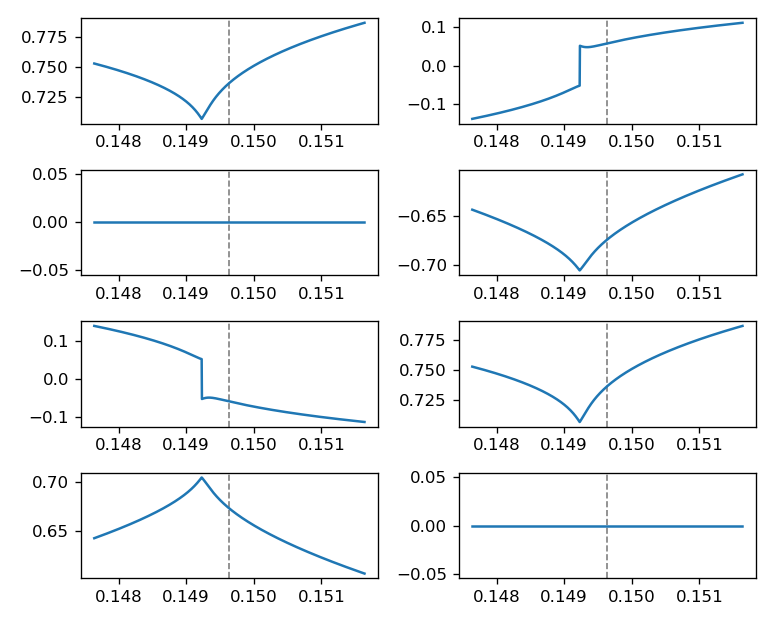

In [239]:
##### y_tmp[scatterer, axis, step in r] #####

fig, ax = plt.subplots(4, 2, dpi=120)

# REAL scatterer 0, x-axis
ax[0, 0].axvline(r_ep, linewidth=1, linestyle='dashed', c='grey')
ax[0, 0].plot(x_tmp, np.real(y_tmp[0, 0, :]))

# REAL scatterer 0, y-axis
ax[0, 1].axvline(r_ep, linewidth=1, linestyle='dashed', c='grey')
ax[0, 1].plot(x_tmp, np.real(y_tmp[0, 1, :]))

# IMAG scatterer 0, x-axis
ax[1, 0].axvline(r_ep, linewidth=1, linestyle='dashed', c='grey')
ax[1, 0].plot(x_tmp, np.imag(y_tmp[0, 0, :]))

# IMAG scatterer 0, y-axis
ax[1, 1].axvline(r_ep, linewidth=1, linestyle='dashed', c='grey')
ax[1, 1].plot(x_tmp, np.imag(y_tmp[0, 1, :]))

# REAL scatterer 1, x-axis
ax[2, 0].axvline(r_ep, linewidth=1, linestyle='dashed', c='grey')
ax[2, 0].plot(x_tmp, np.real(y_tmp[1, 0, :]))

# REAL scatterer 1, y-axis
ax[2, 1].axvline(r_ep, linewidth=1, linestyle='dashed', c='grey')
ax[2, 1].plot(x_tmp, np.real(y_tmp[1, 1, :]))

# IMAG scatterer 1, x-axis
ax[3, 0].axvline(r_ep, linewidth=1, linestyle='dashed', c='grey')
ax[3, 0].plot(x_tmp, np.imag(y_tmp[1, 0, :]))

# IMAG scatterer 1, y-axis
ax[3, 1].axvline(r_ep, linewidth=1, linestyle='dashed', c='grey')
ax[3, 1].plot(x_tmp, np.imag(y_tmp[1, 1, :]))

set_size(5, 4)

plt.tight_layout()    
plt.show()

In [ ]:
##### y_tmp[scatterer, axis, step in r] #####

fig, ax = plt.subplots(1, 2, dpi=120)

# scatterer 0, x-axis
x = [ele.real for ele in y_tmp[0, 0, :]]
y = [ele.imag for ele in y_tmp[0, 0, :]]
ax[0].scatter(x, y, marker='.', s=0.1)

# scatterer 1, y-axis
x = [ele.real for ele in y_tmp[1, 1, :]]
y = [ele.imag for ele in y_tmp[1, 1, :]]
ax[0].scatter(x, y, marker='.', s=0.1)
ax[0].set_ylabel('Imaginary')
ax[0].set_xlabel('Real')

# scatterer 0, y-axis
x = [ele.real for ele in y_tmp[0, 1, :]]
y = [ele.imag for ele in y_tmp[0, 1, :]]
ax[1].scatter(x, y, marker='.', s=0.1)

# scatterer 1, x-axis
x = [ele.real for ele in y_tmp[1, 0, :]]
y = [ele.imag for ele in y_tmp[1, 0, :]]
ax[1].scatter(x, y, marker='.', s=0.1)
ax[1].set_xlabel('Real')

plt.suptitle("Eigenvector components", fontsize=11)

set_size(5, 4)

plt.tight_layout()    
plt.show()

#### norm of the system matrix

In [168]:
tmp = np.zeros(4*n_points)
for i in range(4*n_points):
    tmp[i] = la.norm(interaction_matrix(k_encircling[i], scatterer_locations[:, :, i], alphas))

fig, ax = plt.subplots(1, 1, dpi=120)
ax.plot(tmp)
plt.text(0.08, 0.09, '$k_0$ changes', transform=ax.transAxes)
plt.text(0.3, 0.5, '$r$ changes', transform=ax.transAxes)
plt.text(0.54, 0.87, '$k_0$ changes', transform=ax.transAxes)
plt.text(0.75, 0.5, '$r$ changes', transform=ax.transAxes)
plt.show()

<IPython.core.display.Javascript object>

#### condition number of the matrix

In [169]:
tmp = np.zeros(4*n_points)
for i in range(4*n_points):
    tmp[i] = la.svd(interaction_matrix(k_encircling[i], scatterer_locations[:, :, i], alphas))[1][0]
    tmp[i] /= la.svd(interaction_matrix(k_encircling[i], scatterer_locations[:, :, i], alphas))[1][-1]
    
fig, ax = plt.subplots(1, 1, dpi=120)
ax.plot(tmp)
plt.text(0.08, 0.13, '$k_0$ changes', transform=ax.transAxes)
plt.text(0.3, 0.5, '$r$ changes', transform=ax.transAxes)
plt.text(0.54, 0.83, '$k_0$ changes', transform=ax.transAxes)
plt.text(0.75, 0.5, '$r$ changes', transform=ax.transAxes)
plt.show()

<IPython.core.display.Javascript object>

#### determinant of the matrix

In [170]:
tmp = np.zeros(4*n_points)
for i in range(4*n_points):
    tmp[i] = np.abs(la.det(interaction_matrix(k_encircling[i], scatterer_locations[:, :, i], alphas)))

fig, ax = plt.subplots(1, 1, dpi=120)
ax.plot(tmp)
plt.text(0.08, 0.83, '$k_0$ changes', transform=ax.transAxes)
plt.text(0.3, 0.5, '$r$ changes', transform=ax.transAxes)
plt.text(0.54, 0.13, '$k_0$ changes', transform=ax.transAxes)
plt.text(0.75, 0.5, '$r$ changes', transform=ax.transAxes)
plt.show()

<IPython.core.display.Javascript object>

#### incident field $\phi_i$ at scatterers' locations

<IPython.core.display.Javascript object>


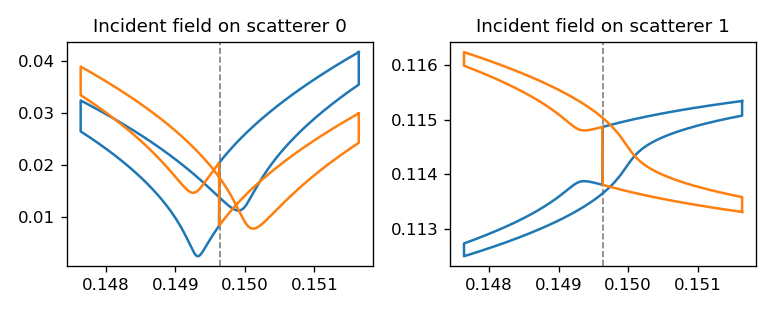

In [171]:
fig, ax = plt.subplots(1, 2, dpi=120)
    
ax[0].axvline(r_ep, linewidth=1, linestyle='dashed', c='grey')
ax[0].plot(r_encircling, np.abs(sol_i_plus[0, :]))
ax[0].plot(r_encircling, np.abs(sol_i_minus[0, :]))
ax[0].set_title("Incident field on scatterer 0", fontsize=11)

ax[1].axvline(r_ep, linewidth=1, linestyle='dashed', c='grey')
ax[1].plot(r_encircling, np.abs(sol_i_plus[1, :]))
ax[1].plot(r_encircling, np.abs(sol_i_minus[1, :]))
ax[1].set_title("Incident field on scatterer 1", fontsize=11)

set_size(5, 2)

plt.tight_layout()    
plt.show()

In [172]:
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')

# ax.plot3D(k_encircling, r_encircling, np.abs(sol_i_plus[0, :]), label="$\phi_{1, +}^{INC}$")
ax.plot3D(k_encircling, r_encircling, np.abs(sol_i_plus[1, :]), label="$\phi_{2, +}^{INC}$")
# ax.plot3D(k_encircling, r_encircling, np.abs(sol_i_minus[0, :]), label="$\phi_{1, -}^{INC}$")
ax.plot3D(k_encircling, r_encircling, np.abs(sol_i_minus[1, :]), label="$\phi_{2, -}^{INC}$")

X, Z = np.meshgrid(np.linspace(k0_ep - 0.05, k0_ep + 0.05, 2), np.linspace(np.min(np.abs(sol_i_plus[1, :])), np.max(np.abs(sol_i_minus[1, :])), 2))
Y = r_ep * np.ones((2, 2))
ax.plot_surface(X, Y, Z, alpha=0.1)  # EP vertical plane
Y, Z = np.meshgrid(np.linspace(r_ep - 0.002, r_ep + 0.002, 2), np.linspace(np.min(np.abs(sol_i_plus[1, :])), np.max(np.abs(sol_i_minus[1, :])), 2))
X = k0_ep * np.ones((2, 2))
ax.plot_surface(X, Y, Z, alpha=0.1)  # EP vertical plane

ax.legend()
ax.view_init(elev=25, azim=140)
ax.set_xlabel("$k0$")
ax.set_ylabel("$r$")
ax.set_title("Incident field on scatterer _", fontsize=11)
ax.set_box_aspect((4, 4, 4))
set_size(6, 6)

plt.show()

<IPython.core.display.Javascript object>

#### total field $\phi_{tot}$ at scatterers' locations

<IPython.core.display.Javascript object>


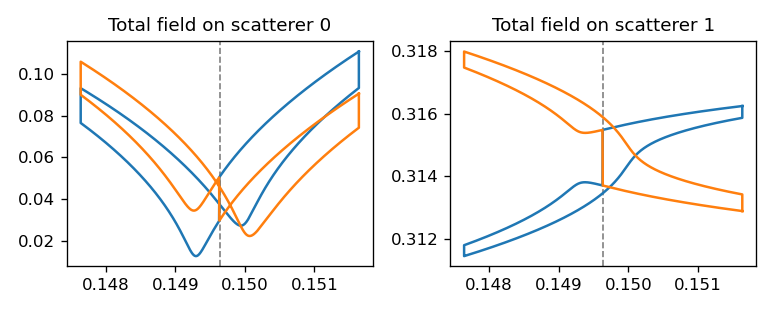

In [173]:
fig, ax = plt.subplots(1, 2, dpi=120)
    
ax[0].axvline(r_ep, linewidth=1, linestyle='dashed', c='grey')
ax[0].plot(r_encircling, np.abs(sol_tot_plus[0, :]))
ax[0].plot(r_encircling, np.abs(sol_tot_minus[0, :]))
ax[0].set_title("Total field on scatterer 0", fontsize=11)

ax[1].axvline(r_ep, linewidth=1, linestyle='dashed', c='grey')
ax[1].plot(r_encircling, np.abs(sol_tot_plus[1, :]))
ax[1].plot(r_encircling, np.abs(sol_tot_minus[1, :]))
ax[1].set_title("Total field on scatterer 1", fontsize=11)

set_size(5, 2)

plt.tight_layout()    
plt.show()

<IPython.core.display.Javascript object>


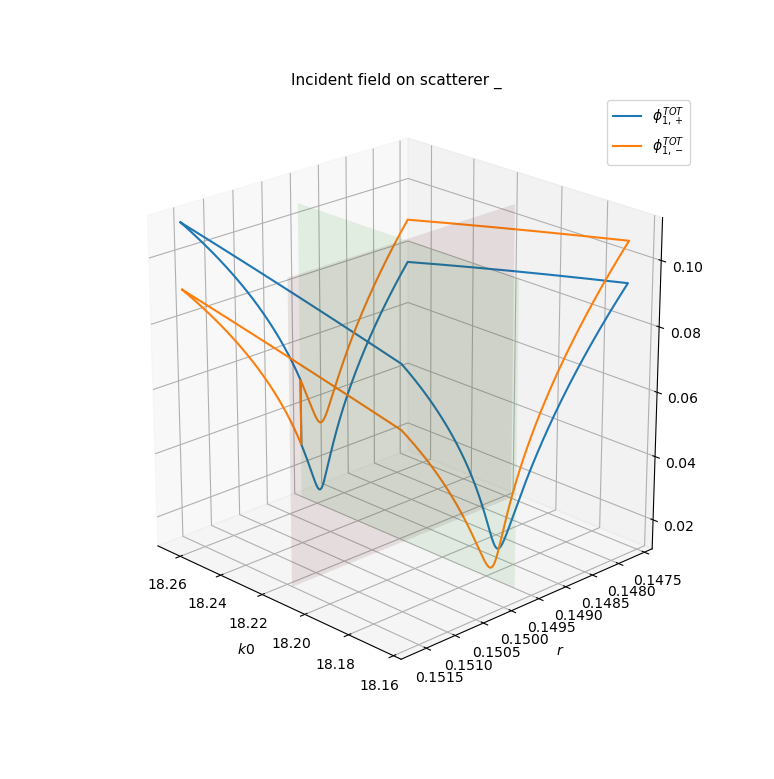

In [174]:
%matplotlib notebook

fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot3D(k_encircling, r_encircling, np.abs(sol_tot_plus[0, :]), label="$\phi_{1, +}^{TOT}$")
# ax.plot3D(k_encircling, r_encircling, np.abs(sol_tot_plus[1, :]), label="$\phi_{2, +}^{TOT}$")
ax.plot3D(k_encircling, r_encircling, np.abs(sol_tot_minus[0, :]), label="$\phi_{1, -}^{TOT}$")
# ax.plot3D(k_encircling, r_encircling, np.abs(sol_tot_minus[1, :]), label="$\phi_{2, -}^{TOT}$")

X, Z = np.meshgrid(np.linspace(k0_ep - 0.05, k0_ep + 0.05, 2), np.linspace(np.min(np.abs(sol_tot_plus[0, :])), np.max(np.abs(sol_tot_minus[0, :])), 2))
Y = r_ep * np.ones((2, 2))
ax.plot_surface(X, Y, Z, alpha=0.1)  # EP vertical plane
Y, Z = np.meshgrid(np.linspace(r_ep - 0.002, r_ep + 0.002, 2), np.linspace(np.min(np.abs(sol_tot_plus[0, :])), np.max(np.abs(sol_tot_minus[0, :])), 2))
X = k0_ep * np.ones((2, 2))
ax.plot_surface(X, Y, Z, alpha=0.1)  # EP vertical plane

ax.legend()
ax.view_init(elev=25, azim=140)
ax.set_xlabel("$k0$")
ax.set_ylabel("$r$")
ax.set_title("Incident field on scatterer _", fontsize=11)
ax.set_box_aspect((4, 4, 4))
set_size(6, 6)

plt.show()

#### square-wave signal when multiple branch cut crossings?

In [177]:
sign_discriminant = "plus"

r_square_wave = np.concatenate((np.linspace(r_ep + 0.00002, r_ep - 0.00002, n_points), 
                                np.linspace(r_ep - 0.00002, r_ep + 0.00002, n_points), 
                                np.linspace(r_ep + 0.00002, r_ep - 0.00002, n_points),
                                np.linspace(r_ep - 0.00002, r_ep + 0.00002, n_points),
                                np.linspace(r_ep + 0.00002, r_ep - 0.00002, n_points),
                                np.linspace(r_ep - 0.00002, r_ep + 0.00002, n_points)))

scatterer_locations = np.zeros((2, 2, n_points*6))
scatterer_locations[0, 0, :] = r_square_wave

sol_square_wave_i = np.zeros((2, n_points*6), dtype=complex)
sol_square_wave_tot = np.zeros((2, n_points*6), dtype=complex)
for i in range(n_points*6):
    sol_square_wave_i[0, i] = calculate_phi_i(sign_discriminant, k0_ep + 0.05, scatterer_locations[:, :, i], alphas)[0]
    sol_square_wave_i[1, i] = calculate_phi_i(sign_discriminant, k0_ep + 0.05, scatterer_locations[:, :, i], alphas)[1]
    sol_square_wave_tot[0, i] = calculate_phi_tot(sign_discriminant, scatterer_locations[0, 0, i], scatterer_locations[0, 1, i], k0_ep + 0.05, scatterer_locations[:, :, i], alphas)
    sol_square_wave_tot[1, i] = calculate_phi_tot(sign_discriminant, scatterer_locations[1, 0, i], scatterer_locations[1, 1, i], k0_ep + 0.05, scatterer_locations[:, :, i], alphas)

In [178]:
fig, ax = plt.subplots(1, 2, dpi=120)
    
# ax[0].plot(np.abs(sol_square_wave_i[0, :]))
ax[0].plot(np.abs(sol_square_wave_i[1, :]))
# ax[1].plot(np.abs(sol_square_wave_tot[0, :]))
ax[1].plot(np.abs(sol_square_wave_tot[1, :]))

ax[0].set_title("Incident field at scatterer 0 and 1", fontsize=11)
ax[1].set_title("Total field at scatterer 0 and 1", fontsize=11)
set_size(5, 2)

plt.tight_layout()    
plt.show()

<IPython.core.display.Javascript object>

#### square-wave signal when multiple branch cut crossings? - VIDEO

In [179]:
sign_discriminant = "plus"

n_points = 100

r_square_wave = np.concatenate((np.linspace(r_ep + 0.000005, r_ep - 0.00002, n_points), 
                                np.linspace(r_ep - 0.00002, r_ep + 0.000005, n_points)))

scatterer_locations = np.zeros((2, 2, n_points*2))
scatterer_locations[0, 0, :] = r_square_wave

sol_square_wave_i = np.zeros((2, n_points*2), dtype=complex)
sol_square_wave_tot = np.zeros((2, n_points*2), dtype=complex)
for i in range(n_points*2):
    sol_square_wave_i[0, i] = calculate_phi_i(sign_discriminant, k0_ep + 0.05, scatterer_locations[:, :, i], alphas)[0]
    sol_square_wave_i[1, i] = calculate_phi_i(sign_discriminant, k0_ep + 0.05, scatterer_locations[:, :, i], alphas)[1]
    sol_square_wave_tot[0, i] = calculate_phi_tot(sign_discriminant, scatterer_locations[0, 0, i], scatterer_locations[0, 1, i], k0_ep + 0.05, scatterer_locations[:, :, i], alphas)
    sol_square_wave_tot[1, i] = calculate_phi_tot(sign_discriminant, scatterer_locations[1, 0, i], scatterer_locations[1, 1, i], k0_ep + 0.05, scatterer_locations[:, :, i], alphas)

<IPython.core.display.Javascript object>


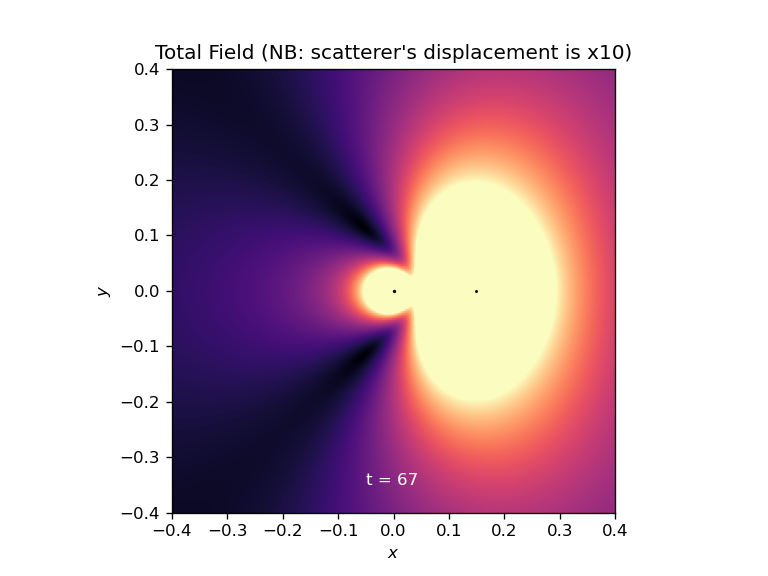

In [182]:
%matplotlib notebook

# NB: the movement of the second scatterer is multiplied x10 

sign_eigvect = "plus"

# meshgrid
xv, yv = lim * np.linspace(-1, 1, 200), lim * np.linspace(-1, 1, 200)
X, Y = np.meshgrid(xv, yv)

# Evaluate total field at the scatterer's locations
# phi_tot_values = [
#     np.abs(calculate_phi_tot(dim, scatterer_locations[0, 0], scatterer_locations[0, 1], phi_s, scatterer_locations, alphas)),
#     np.abs(calculate_phi_tot(dim, scatterer_locations[1, 0], scatterer_locations[1, 1], phi_s, scatterer_locations, alphas)),
# ]

fig = plt.figure(dpi=120)

plt.scatter(scatterer_locations[1, 0, 0], scatterer_locations[1, 1, 0], c='k', s=1)
y_init_points, = plt.plot(scatterer_locations[0, 0, 0], scatterer_locations[0, 1, 0], marker='.', markersize=1.5, c='k')
y_init = plt.imshow(np.abs(calculate_phi_tot(sign_eigvect, X, Y, k_encircling[0], scatterer_locations[:, :, 0], alphas)), origin="lower",
           extent=(xv[0], xv[-1], yv[0], yv[-1]),
           cmap="magma", aspect=1)
time_init = plt.text(-0.05, -0.35, "t = 0", c='w')
plt.clim(0, np.max(np.abs(calculate_phi_tot(sign_eigvect, X, Y, k_encircling[0], scatterer_locations[:, :, 0], alphas)))/40)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Total Field (NB: scatterer's displacement is x10)")

n_frames = 100
def animate(i):
    i_time = int(i / n_frames * 100)
    y_init_points.set_data(scatterer_locations[0, 0, 0]+(scatterer_locations[0, 0, 0 + i]-scatterer_locations[0, 0, 0])*10, scatterer_locations[0, 1, 0 + i])
    y_init.set_data(np.abs(calculate_phi_tot(sign_eigvect, X, Y, k_encircling[0], scatterer_locations[:, :, 0 + i], alphas)))
    time_init.set_text("t = {0:d}".format(i_time))
    return y_init_points, y_init, time_init

animation.FuncAnimation(fig, animate, frames=n_frames, interval=0., blit=True)

#### total field $\phi_{tot}$ heatmap

<IPython.core.display.Javascript object>


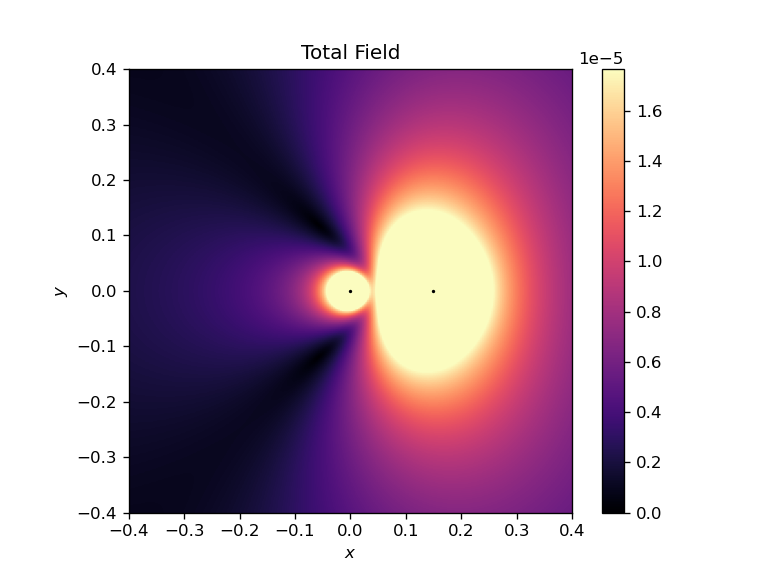

In [150]:
# ############
# # scatterer_locations[index_scatt, axis, "time_step"]
# ############
# scatterer_locations = np.zeros((2, 2, n_points*4))
# scatterer_locations[0, 0, :] = r_encircling

sign_eigvect = "plus"

# meshgrid
xv, yv = lim * np.linspace(-1, 1, 200), lim * np.linspace(-1, 1, 200)
X, Y = np.meshgrid(xv, yv)

# Evaluate total field at the scatterer's locations
# phi_tot_values = [
#     np.abs(calculate_phi_tot(dim, scatterer_locations[0, 0], scatterer_locations[0, 1], phi_s, scatterer_locations, alphas)),
#     np.abs(calculate_phi_tot(dim, scatterer_locations[1, 0], scatterer_locations[1, 1], phi_s, scatterer_locations, alphas)),
# ]

# evaluate phi_tot on meshgrid
phi_tot = calculate_phi_tot(sign_eigvect, X, Y, k_encircling[0], scatterer_locations[:, :, 100], alphas)

fig, ax = plt.subplots(dpi=120)

plt.scatter(scatterer_locations[1, 0, 100], scatterer_locations[1, 1, 100], c='k', s=1)
plt.scatter(scatterer_locations[0, 0, 100], scatterer_locations[0, 1, 100], c='k', s=1)
plt.imshow(np.abs(phi_tot),
           origin="lower",
           extent=(xv[0], xv[-1], yv[0], yv[-1]),
           cmap="magma")
# ax.text(xv[0] + 0.1, yv[-1] - 0.1,
#         "$|\\phi(\mathbf{x}_%i)| = %.2lf$\n"
#         "$|\\phi(\mathbf{x}_%i)| = %.2lf$" %
#         (1, np.abs(phi_tot_values[0]),
#          2, np.abs(phi_tot_values[1])),
#         ha="left",
#         va="top",
#         size=10,
#         bbox=dict(boxstyle='round', fc='w'))
plt.colorbar()
plt.clim(0, np.max(np.abs(phi_tot))/30)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Total Field")

plt.show()

#### total field $\phi_{tot}$ heatmap - VIDEO

In [11]:
# phi_s just needs the DISCRIMINANT in the first component
# this is what this phi_s shows!!

def calculate_phi_s(sign_discrim, k0, scatterer_locations, alphas):
    r = np.abs(scatterer_locations[1, 0] - scatterer_locations[0, 0])
    G_12 = np.exp(1j * k0 * r) / (4 * np.pi * r)
    discrim =  np.sqrt((alphas[0] - alphas[1])**2 + 4 * G_12**2 * alphas[0]**2 * alphas[1]**2)
    if sign_discrim == "plus":
        result = np.array([discrim, 0.001], dtype=complex) # first eigenvector
    else:
        raise Exception('Sign of the discriminant must be "plus" or "minus"!')
    return result


In [12]:
def discrim(sign_discrim, k0, scatterer_locations, alphas):
    r = np.abs(scatterer_locations[1, 0] - scatterer_locations[0, 0])
    G_12 = np.exp(1j * k0 * r) / (4 * np.pi * r)
    result =  np.sqrt((alphas[0] - alphas[1])**2 + 4 * G_12**2 * alphas[0]**2 * alphas[1]**2)
    return result

<IPython.core.display.Javascript object>


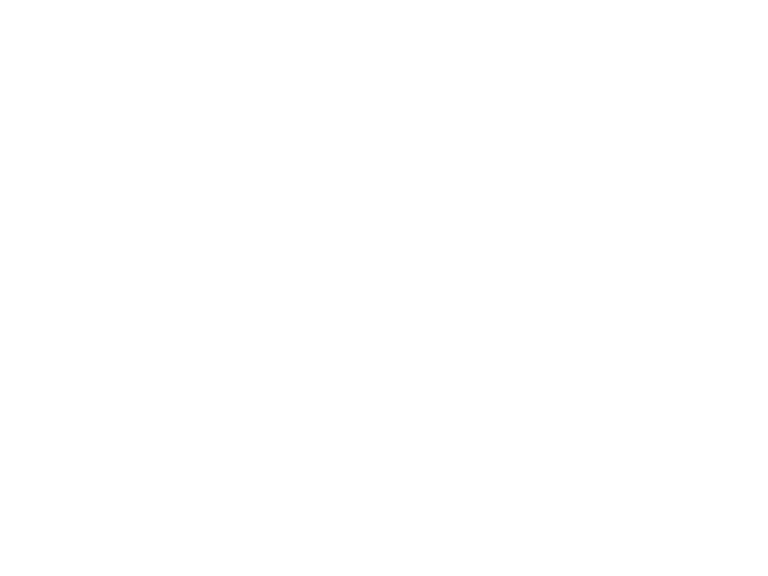

In [13]:
fig, ax = plt.subplots(dpi=120)

ax.plot(r_encircling, np.imag(discrim("plus", k_encircling[0], scatterer_locations, alphas)), 'C1', linewidth=1, label="imag")
ax.plot(r_encircling, np.real(discrim("plus", k_encircling[0], scatterer_locations, alphas)), 'C0', linewidth=1, label="real")
ax.plot(r_encircling, np.abs(discrim("plus", k_encircling[0], scatterer_locations, alphas)), 'C2', linewidth=1, dashes=[4, 10], label="abs")
ax.legend()

<IPython.core.display.Javascript object>


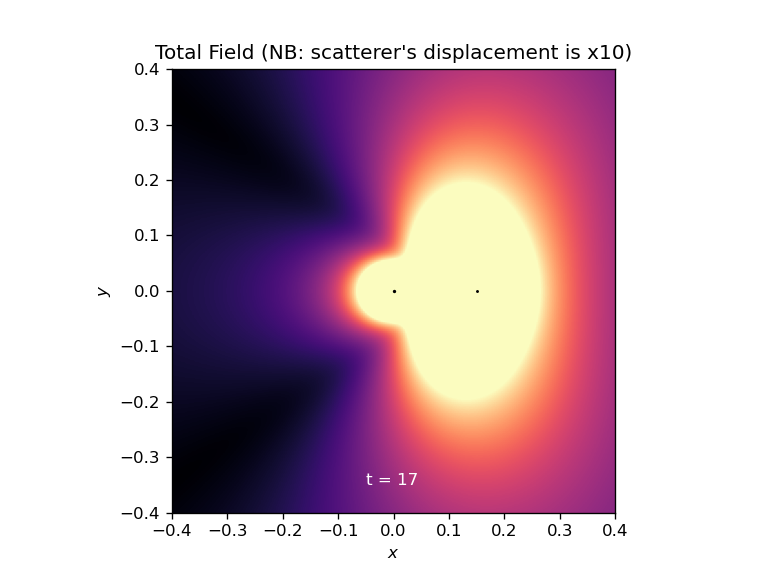

In [14]:
%matplotlib notebook

# NB: the movement of the second scatterer is multiplied x10 

sign_eigvect = "plus"

# meshgrid
xv, yv = lim * np.linspace(-1, 1, 200), lim * np.linspace(-1, 1, 200)
X, Y = np.meshgrid(xv, yv)

# Evaluate total field at the scatterer's locations
# phi_tot_values = [
#     np.abs(calculate_phi_tot(dim, scatterer_locations[0, 0], scatterer_locations[0, 1], phi_s, scatterer_locations, alphas)),
#     np.abs(calculate_phi_tot(dim, scatterer_locations[1, 0], scatterer_locations[1, 1], phi_s, scatterer_locations, alphas)),
# ]

fig = plt.figure(dpi=120)

plt.scatter(scatterer_locations[1, 0, 0], scatterer_locations[1, 1, 0], c='k', s=1)
y_init_points, = plt.plot(scatterer_locations[0, 0, 3400], scatterer_locations[0, 1, 3400], marker='.', markersize=1.5, c='k')
y_init = plt.imshow(np.abs(calculate_phi_tot(sign_eigvect, X, Y, k_encircling[0], scatterer_locations[:, :, 3400], alphas)), origin="lower",
           extent=(xv[0], xv[-1], yv[0], yv[-1]),
           cmap="magma", aspect=1)
time_init = plt.text(-0.05, -0.35, "t = 0", c='w')
plt.clim(0, np.max(np.abs(calculate_phi_tot(sign_eigvect, X, Y, k_encircling[0], scatterer_locations[:, :, 3400], alphas)))/30)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.title("Total Field (NB: scatterer's displacement is x10)")

n_frames = 200
def animate(i):
    i_time = int(i / n_frames * 100)
    y_init_points.set_data(scatterer_locations[0, 0, 3400]+(scatterer_locations[0, 0, 3400 + i]-scatterer_locations[0, 0, 3400])*10, scatterer_locations[0, 1, 3400 + i])
    y_init.set_data(np.abs(calculate_phi_tot(sign_eigvect, X, Y, k_encircling[0], scatterer_locations[:, :, 3400 + i], alphas)))
    time_init.set_text("t = {0:d}".format(i_time))
    return y_init_points, y_init, time_init

animation.FuncAnimation(fig, animate, frames=n_frames, interval=0.001, blit=True)

### NO Exceptional points in parameter space - normalized interaction matrix

In [ ]:
y_tmp_1_norm = [spl.eig(interaction_matrix_r_normalized(alphas, i))[0][0] for i in r_scan]
y_tmp_2_norm = [spl.eig(interaction_matrix_r_normalized(alphas, i))[0][1] for i in r_scan]

In [ ]:
fig, ax = plt.subplots(dpi=120)

ax.scatter(r_scan, np.real(y_tmp_1_norm), s=0.1)
ax.scatter(r_scan, np.real(y_tmp_2_norm), s=0.1)
ax.axvline(r_ep, c='gray', linestyle='dashed', linewidth=1)
ax.set_xlabel("Scatterers' distance $r$", fontsize="12")
ax.set_ylabel("$Re\{\lambda\}$", fontsize="12")

plt.show()

In [ ]:
fig, ax = plt.subplots(dpi=120)

ax.scatter(r_scan, np.imag(y_tmp_1_norm), s=0.1)
ax.scatter(r_scan, np.imag(y_tmp_2_norm), s=0.1)
ax.axvline(r_ep, c='gray', linestyle='dashed', linewidth=1)
ax.set_xlabel("Scatterers' distance $r$", fontsize="12")
ax.set_ylabel("$Im\{\lambda\}$", fontsize="12")

plt.show()

In [ ]:
%matplotlib notebook

ax = plt.axes(projection='3d')

def set_size(w, h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
set_size(5,5)

ax.scatter3D(np.real(y_tmp_1_norm), np.imag(y_tmp_1_norm), r_scan, s=0.2)
ax.scatter3D(np.real(y_tmp_2_norm), np.imag(y_tmp_2_norm), r_scan, s=0.2)

ax.set_xlabel("$Re\{\lambda\}$", fontsize="14")
ax.set_ylabel("$Im\{\lambda\}$", fontsize="14")
ax.set_zlabel("Scatterers' distance $r$", fontsize="14")